In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [4]:
# HIDDEN
def plot_loss(y_vals, xlim, loss_fn):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(5, 3))
    plt.plot(thetas, losses, zorder=1)
    plt.xlim(*xlim)
    plt.title(loss_fn.__name__)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Loss')
    
def plot_theta_on_loss(y_vals, theta, loss_fn, **kwargs):
    loss = loss_fn(theta, y_vals)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([theta], [loss], **{**default_args, **kwargs})

def plot_tangent_on_loss(y_vals, theta, loss_fn, eps=1e-6):
    slope = ((loss_fn(theta + eps, y_vals) - loss_fn(theta - eps, y_vals))
             / (2 * eps))
    xs = np.arange(theta - 1, theta + 1, 0.05)
    ys = loss_fn(theta, y_vals) + slope * (xs - theta)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')

## Batch Gradient Descent

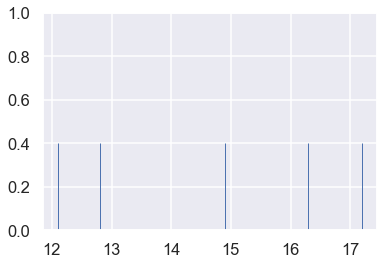

In [9]:
pts = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
sns.rugplot(pts, height=0.4)

In [10]:
def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

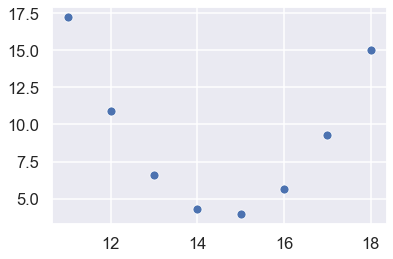

In [12]:
thetas = np.arange(11, 19, 1)
mses = [mse(theta, pts) for theta in thetas]
sns.scatterplot(thetas, mses);

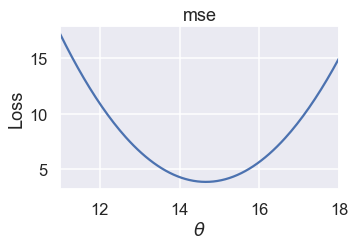

In [13]:
plot_loss(pts, (11, 18), mse)

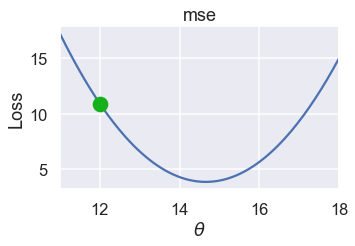

In [14]:
start = 12
plot_loss(pts, (11, 18), mse)
plot_theta_on_loss(pts, start, mse)

In [5]:
def grad_mse(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

In [16]:
def grad_descent_one(theta, y_vals, grad_loss, alpha=0.3):
    return theta - alpha * grad_loss(theta, y_vals)

In [18]:
grad_descent_one(start, pts, grad_mse)

13.596

In [25]:
def plot_one_gd_iter(y_vals, theta, loss_fn, grad_loss, alpha=0.3):
    new_theta = grad_descent_one(theta, y_vals, grad_loss, alpha)
    plot_loss(pts, (11, 18), loss_fn)
    plot_theta_on_loss(pts, theta, loss_fn, c='none',
                       edgecolor=sns.xkcd_rgb['green'], linewidth=2)
    plot_theta_on_loss(pts, new_theta, loss_fn)
    print(f'old theta: {theta}')
    print(f'new theta: {new_theta}')

old theta: 12
new theta: 13.596


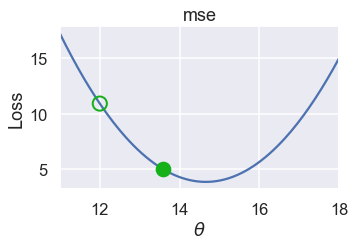

In [20]:
plot_one_gd_iter(pts, start, mse, grad_mse)

old theta: 13.6
new theta: 14.236


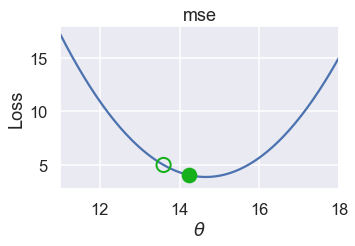

In [21]:
plot_one_gd_iter(pts, 13.6, mse, grad_mse)

old theta: 14.5
new theta: 14.596


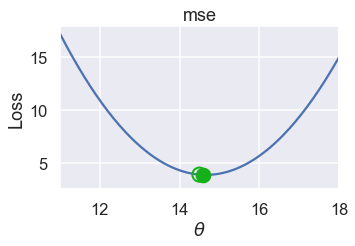

In [23]:
plot_one_gd_iter(pts, 14.5, mse, grad_mse)

In [24]:
np.mean(pts)

14.66

## Adjusting the Learning Rate

In [48]:
def plot_n_gd_iter(n, y_vals, theta, loss_fn, grad_loss, alpha=0.3):
    for _ in range(n):
        new_theta = grad_descent_one(theta, y_vals, grad_loss, alpha)
        plot_loss(pts, (11, 18), loss_fn)
        plot_theta_on_loss(pts, theta, loss_fn, c='none',
                           edgecolor=sns.xkcd_rgb['green'], linewidth=2)
        plot_theta_on_loss(pts, new_theta, loss_fn)
        theta = new_theta
        plt.show()

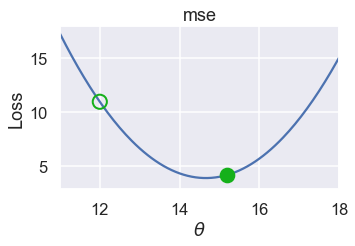

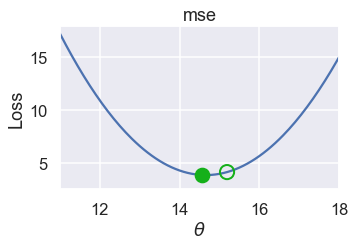

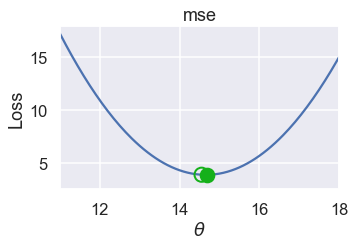

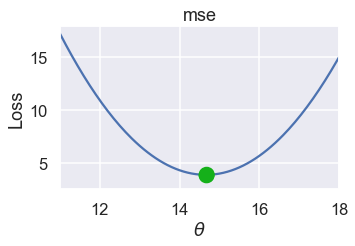

In [53]:
alpha = 0.6
plot_n_gd_iter(4, pts, start, mse, grad_mse, alpha)

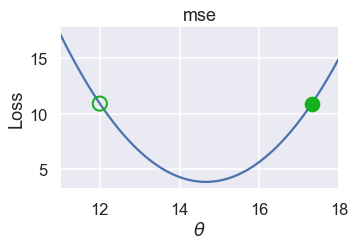

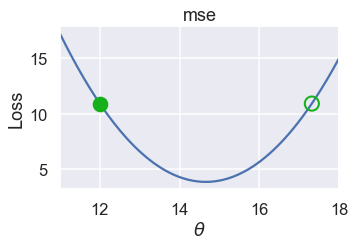

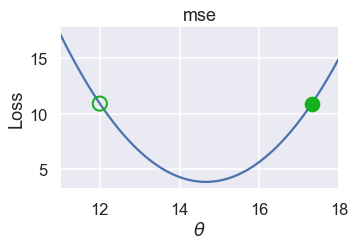

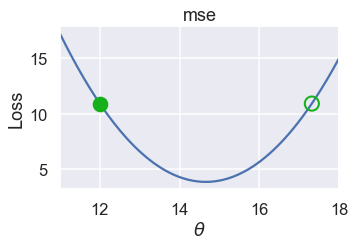

In [49]:
alpha = 1
plot_n_gd_iter(4, pts, start, mse, grad_mse, alpha)

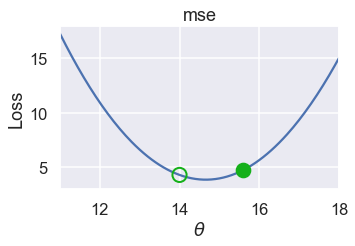

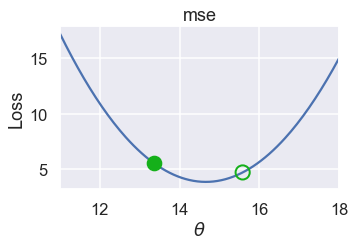

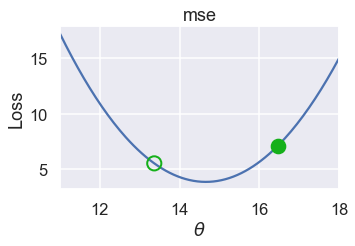

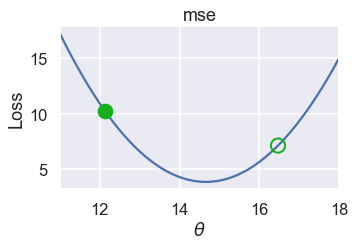

In [50]:
alpha = 1.2
plot_n_gd_iter(4, pts, 14, mse, grad_mse, alpha)

## Fitting a Linear Model

In [54]:
from scipy.optimize import minimize as sci_min
def minimize(loss_fn, grad_loss_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize loss_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return loss_fn(theta, X, y)
    def gradient(theta):
        return grad_loss_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress and iters % progress == 0:
            print(f'theta: {theta} | loss: {loss_fn(theta, X, y):.2f}')
        iters += 1
        
    print_theta(theta)
    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

In [55]:
def linear_model(thetas, X):
    '''Returns predictions by a linear model on x_vals.'''
    return X @ thetas

In [56]:
def mse_loss(thetas, X, y):
    return np.mean((y - linear_model(thetas, X)) ** 2)

In [58]:
def grad_mse_loss(thetas, X, y):
    n = len(X)
    return -2 / n * (X.T @ y - X.T @ X @ thetas)